# ML Simulation Evaluation
In this notebook you are going to control both the SDV and other agents using a CNN-based policy in a closed-loop fashion.

**Note: to learn more about closed-loop evaluation refer to our [planning notebook](../planning/closed_loop_test.ipynb).**

![simulation-example](https://github.com/lyft/l5kit/blob/master/images/simulation/simulation_example.svg?raw=1)


## What can we use ML simulation for?
Simulating other agents **is crucial to remove false positive interventions**, which occur when agents are log-replayed.
As an example, imagine if our SDV was slower compared to the one in the data log. In this situation the car behind us may bump into us if it's just being replayed from the log. Differently, if that agent is equipped with a ML policy it will be able to react and slow down before colliding with the SDV.

When evaluating a policy for the SDV, ML simulation can therefore help in reducing the noise introduced in the metrics by the non-reactive log replayed agents. 

![simulation-bump](https://github.com/lyft/l5kit/blob/master/images/simulation/simulation_bump.svg?raw=1)

## Why is ML simulation difficult?
Clearly, the policy from the previous scenario must be smart enough to model a chasing car that is:
- **realistic**: such that a simulated agent should be indistinguishable from a log-replayed one in standard conditions;
- **reactive**: such that a simulated agent can react to the SDV and other agents around it in the same way a real agents would do on the road. 

In practice, **solving ML simulation is at least as hard as solving planning for the SDV itself**.

### Imports

In [1]:
import torch

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset, filter_agents_by_frames
from l5kit.dataset import EgoDataset
from l5kit.rasterization import build_rasterizer

from l5kit.cle.closed_loop_evaluator import ClosedLoopEvaluator, EvaluationPlan
from l5kit.cle.metrics import (CollisionFrontMetric, CollisionRearMetric, CollisionSideMetric,
                               DisplacementErrorL2Metric, DistanceToRefTrajectoryMetric)
from l5kit.cle.validators import RangeValidator, ValidationCountingAggregator
from l5kit.simulation.dataset import SimulationConfig
from l5kit.simulation.unroll import ClosedLoopSimulator
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from l5kit.visualization.visualizer.zarr_utils import simulation_out_to_visualizer_scene, simulation_ego_out_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    print("Not running in Google Colab.")
    os.environ["L5KIT_DATA_FOLDER"] = "/home/ubuntu/level5_data/"

Not running in Google Colab.


In [3]:
# set env variable for data
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the model

We load here two models:
- the `simulation_model.pt` will be used to control the agents around the SDV;
- the `ego_model.pt` will be used to control the SDV itself;

Clearly, nothing prevents us from replacing one model with the other (or with a completely different one, provided the input and output stay the same)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

simulation_model_path = "/home/ubuntu/models/simulation_model_20210416_5steps.pt"
simulation_model = torch.load(simulation_model_path).to(device)
simulation_model = simulation_model.eval()

ego_model_path = "/home/ubuntu/models/planning_model_20210421_5steps.pt"
ego_model = torch.load(ego_model_path).to(device)
ego_model = ego_model.eval()

torch.set_grad_enabled(False)

/home/ubuntu/.local/share/virtualenvs/l5kit-005i5ETK/lib/python3.9/site-packages/torch/serialization.py:589: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


## Load the evaluation data


In [5]:
# ===== INIT DATASET
eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
mapAPI = MapAPI.from_cfg(dm ,cfg)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [6]:
rasterizer.raster_size[0]



224

## Define some simulation properties
We define here some common simulation properties such as the length of the simulation and how many scene to simulate.

**NOTE: these properties have a significant impact on the execution time. We suggest you to increase them only if your setup includes a GPU**

In [6]:
# scenes_to_unroll = [0, 10, 20]
# scenes_to_unroll = list(range(100))
# num_simulation_step_example1 = 50
# num_simulation_step_example2 = 50
scenes_to_unroll = list(range(1))
num_simulation_step_example1 = 20
num_simulation_step_example2 = 20

# Measuring agents realism
The first set of metric we're interested in answers to the question _"how realistic are the simulated agents?"_

To this end, we can run a simulation with the following features:
- agents only are simulated (we're not interested in the SDV for now);
- only agents in the initial frames are simulated (this avoid interactions between log-replayed and simulated agents);
- once an agent is simulated, it's simulated until the end of the episode (note `distance_th_far=500`).

**Quantitatively**: we can measure the L2 displacement between the log-replayed and the simulated agents at each time step (we can report this in terms of FDE, ADE, etc..)

**Qualitatively**: we can inspect the resulting simulation overlayed with the original trajectories.

In [7]:
# sim_cfg = SimulationConfig(use_ego_gt=True, use_agents_gt=False, disable_new_agents=True,
#                            distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_step_example1,
#                            start_frame_index=0, show_info=True)

# sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_agents=simulation_model)

sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=True,
                           distance_th_far=500, distance_th_close=50, num_simulation_steps=num_simulation_step_example1,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=ego_model)

sim_outs = sim_loop.unroll(scenes_to_unroll)

/home/ubuntu/src/l5kit/l5kit/l5kit/data/zarr_dataset.py:226: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/ubuntu/src/l5kit/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
sim_outs[0]

# Quantitative evaluation
We can measure L2 displacements between annotated and simulated positions and report them in terms of per step ADE.
This error reflects how far the simulated agents are from the annotated ones.

Because the annotated agents come from realistic log-replays, **this value can be interpreted as a way of measuring how realistic the simulation is**.

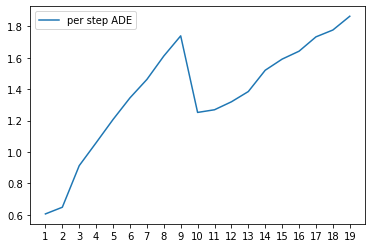

In [10]:
errors_at_step = defaultdict(list)
for sim_out in sim_outs: # for each scene
    for idx_step, agents_in_out in enumerate(sim_out.agents_ins_outs):  # for each step
        for agent_in_out in agents_in_out:  # for each agent
            annot_pos = agent_in_out.inputs["target_positions"][0]
            pred_pos = agent_in_out.outputs["positions"][0]
            if agent_in_out.inputs["target_availabilities"][0] > 0:
                errors_at_step[idx_step + 1].append(np.linalg.norm(pred_pos - annot_pos))

time_steps = np.asarray(list(errors_at_step.keys()))
errors = np.asarray([np.mean(errors_at_step[k]) for k in errors_at_step])
plt.plot(time_steps, errors, label="per step ADE")
plt.xticks(time_steps)
plt.legend()
plt.show()

# Qualitative evaluation
We can show a visualisation of the scene using our bokeh-based visualzer.

For each scene:
- the simulated scene is played;
- both replayed and simulated trajectory can be toggled.

The visualisation is interactive, **try to hover over an agent to show more information about it**

In [8]:
output_notebook()
for sim_out in sim_outs: # for each scene
    vis_in = simulation_out_to_visualizer_scene(sim_out, mapAPI)
    show(visualize(sim_out.scene_id, vis_in))

Loading BokehJS ...

In [9]:
output_notebook()
for sim_out in sim_outs: # for each scene
    vis_in = simulation_ego_out_to_visualizer_scene(sim_out, mapAPI)
    show(visualize(sim_out.scene_id, vis_in))

Loading BokehJS ...

# Measuring ego metrics with simulated agents
The second set of metric we're interested in answer to the question _"are simulated agents helpful when evaluating SDV?"_

To this end, we can run a simulation with the following features:
- both agents and the SDV are simulated (so we can measure interactions between them);
- only agents close to the SDV are simulated (this is the only set we really care about in terms of interaction with the SDV);
- the set of simulated agents is variable and depends on the proximity of SDV (as the SDV moves in the scene, the agents proximity changes).

**Quantitatively**, we can measure how these agents affect the closed-loop metrics for the SDV by comparing the results with those from the log-replayed agents.

**Qualitatively**, we can inspect the resulting simulation overlayed with the original trajectories.

# Quantitative evaluation

We define here which metrics are of interest and how to evaluate each one of them. These metrics applies to the SDV only and are the same used in the [closed-loop planning notebook](../planning/closed_loop_test.ipynb).

If you want to know more about how each component (metrics, validators, aggregators) of the evaluation stack works, please refer to the source code

In [12]:
metrics = [DisplacementErrorL2Metric(),
           DistanceToRefTrajectoryMetric(),
           CollisionFrontMetric(),
           CollisionRearMetric(),
           CollisionSideMetric()]

# validators = [RangeValidator("displacement_error_l2_validator", DisplacementErrorL2Metric, max_value=30),
#               RangeValidator("distance_ref_trajectory_validator", DistanceToRefTrajectoryMetric, max_value=4),
#               RangeValidator("collision_front_validator", CollisionFrontMetric, max_value=0),
#               RangeValidator("collision_rear_validator", CollisionRearMetric, max_value=0),
#               RangeValidator("collision_side_validator", CollisionSideMetric, max_value=0),
#               ]

validators = [RangeValidator("displacement_error_l2_validator", DisplacementErrorL2Metric, max_value=5),
              RangeValidator("distance_ref_trajectory_validator", DistanceToRefTrajectoryMetric, max_value=1),
              RangeValidator("collision_front_validator", CollisionFrontMetric, max_value=0),
              RangeValidator("collision_rear_validator", CollisionRearMetric, max_value=0),
              RangeValidator("collision_side_validator", CollisionSideMetric, max_value=0),
              ]

intervention_validators = ["displacement_error_l2_validator",
                           "distance_ref_trajectory_validator",
                           "collision_front_validator",
                           "collision_rear_validator",
                           "collision_side_validator"]

cle_evaluator = ClosedLoopEvaluator(EvaluationPlan(metrics=metrics,
                                    validators=validators,
                                    composite_metrics=[],
                                    intervention_validators=intervention_validators))

### Evaluating with simulated agents
In this evaluation **both the models for planning and simulation are enabled**

In [13]:
sim_cfg = SimulationConfig(use_ego_gt=False, use_agents_gt=False, disable_new_agents=False,
                           distance_th_far=30, distance_th_close=15, num_simulation_steps=num_simulation_step_example2,
                           start_frame_index=0, show_info=True)

sim_loop = ClosedLoopSimulator(sim_cfg, eval_dataset, device, model_ego=ego_model, model_agents=simulation_model)

sim_outs = sim_loop.unroll(scenes_to_unroll)

cle_evaluator.evaluate(sim_outs)
validation_results = cle_evaluator.validation_results()
agg = ValidationCountingAggregator().aggregate(validation_results)
cle_evaluator.reset()

/home/ubuntu/src/l5kit/l5kit/l5kit/data/zarr_dataset.py:226: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")
/home/ubuntu/src/l5kit/l5kit/l5kit/simulation/utils.py:107: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  new_dataset = ChunkedDataset("")


  0%|          | 0/20 [00:00<?, ?it/s]

### Evaluating with log-replayed agents
In this evaluation **only the model for planning is enabled**

In [14]:
# sim_cfg_log = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=False,
#                            distance_th_far=30, distance_th_close=15, num_simulation_steps=num_simulation_step_example2,
#                            start_frame_index=0, show_info=True)
sim_cfg_log = SimulationConfig(use_ego_gt=False, use_agents_gt=True, disable_new_agents=False,
                           distance_th_far=30, distance_th_close=15, num_simulation_steps=None,
                           start_frame_index=0, show_info=True)

sim_loop_log = ClosedLoopSimulator(sim_cfg_log, eval_dataset, device, model_ego=ego_model)
sim_outs_log = sim_loop_log.unroll(scenes_to_unroll)

cle_evaluator.evaluate(sim_outs_log)
validation_results_log = cle_evaluator.validation_results()
agg_log = ValidationCountingAggregator().aggregate(validation_results_log)
cle_evaluator.reset()

  0%|          | 0/248 [00:00<?, ?it/s]

### Comparing the two runs
We compare here the result of replacing log-replayed agents with simulated one.

In [58]:
fields = ["metric", "log_replayed agents", "simulated agents"]
table = PrettyTable(field_names=fields)
for metric_name in agg_log:
    table.add_row([metric_name, agg_log[metric_name].item(), agg[metric_name].item()])
print(table)

+-----------------------------------+---------------------+------------------+
|               metric              | log_replayed agents | simulated agents |
+-----------------------------------+---------------------+------------------+
|  displacement_error_l2_validator  |          5          |        1         |
| distance_ref_trajectory_validator |          5          |        0         |
|     collision_front_validator     |          0          |        0         |
|      collision_rear_validator     |          2          |        0         |
|      collision_side_validator     |          1          |        0         |
+-----------------------------------+---------------------+------------------+


# Qualitative evaluation
Similarly to the previous example, also here we can show an interactive plot of the simulated scene. Because also the SDV is controlled now, its trajectory are shown in the plot

In [ ]:
output_notebook()
for sim_out in sim_outs: # for each scene
    vis_in = simulation_out_to_visualizer_scene(sim_out, mapAPI)
    show(visualize(sim_out.scene_id, vis_in))